# Steps to choose best model between ARIMA and SARIMA

## Load data

In [1]:
PATH = "../../../data/EIA/fuel_type_data_california.parquet"

In [2]:
import pandas as pd
df = pd.read_parquet(PATH)

df

,period,respondent,respondent-name,fueltype,type-name,value,value-units
0,2025-04-22 20:00:00-07:00,CAL,California,BAT,Battery storage,179,megawatthours
1,2025-04-22 20:00:00-07:00,CAL,California,COL,Coal,216,megawatthours
...,...,...,...,...,...,...,...
452546,2018-12-31 17:00:00-07:00,CAL,California,WAT,Hydro,2880,megawatthours
452547,2018-12-31 17:00:00-07:00,CAL,California,WND,Wind,2628,megawatthours


## Preprocess data

### Datetime column object

In [3]:
COLUMN_DATETIME = "period"

x = pd.to_datetime(df[COLUMN_DATETIME], utc=True)
x

0        2025-04-23 03:00:00+00:00
1        2025-04-23 03:00:00+00:00
                    ...           
452546   2019-01-01 00:00:00+00:00
452547   2019-01-01 00:00:00+00:00
Name: period, Length: 452548, dtype: datetime64[us, UTC]

In [4]:
df[COLUMN_DATETIME] = x

### Local timezones

In [5]:
TIMEZONE = 'America/Los_Angeles'

x = df[COLUMN_DATETIME]

try:
    x = x.dt.tz_convert(TIMEZONE)
except Exception as e:
    print(e)

x

0        2025-04-22 20:00:00-07:00
1        2025-04-22 20:00:00-07:00
                    ...           
452546   2018-12-31 16:00:00-08:00
452547   2018-12-31 16:00:00-08:00
Name: period, Length: 452548, dtype: datetime64[us, America/Los_Angeles]

In [6]:
df[COLUMN_DATETIME] = x

### Available series inside dataset

In [7]:
COLUMN_CATEGORIES = ['respondent', 'respondent-name', 'fueltype', 'type-name']

df[COLUMN_CATEGORIES].drop_duplicates().style

,respondent,respondent-name,fueltype,type-name
0,CAL,California,BAT,Battery storage
1,CAL,California,COL,Coal
2,CAL,California,GEO,Geothermal
3,CAL,California,NG,Natural Gas
4,CAL,California,NUC,Nuclear
5,CAL,California,OIL,Petroleum
6,CAL,California,OTH,Other
7,CAL,California,PS,Pumped storage
8,CAL,California,SNB,Solar with integrated battery storage
9,CAL,California,SUN,Solar


### Set index

The index is composed by the columns that uniquely identify the rows. The datetime column must be present.

In [8]:
COLUMN_CATEGORIES = ['respondent-name', 'type-name']

idx = COLUMN_CATEGORIES + [COLUMN_DATETIME]
x = df.set_index(idx).sort_index()

x

respondent fueltype  \
respondent-name type-name       period                                          
California      Battery storage 2025-01-01 01:00:00-08:00        CAL      BAT   
                                2025-01-01 02:00:00-08:00        CAL      BAT   
...                                                              ...      ...   
                Wind            2025-04-22 19:00:00-07:00        CAL      WND   
                                2025-04-22 20:00:00-07:00        CAL      WND   

                                                           value  \
respondent-name type-name       period                             
California      Battery storage 2025-01-01 01:00:00-08:00     11   
                                2025-01-01 02:00:00-08:00     -1   
...                                                          ...   
                Wind            2025-04-22 19:00:00-07:00   3419   
                                2025-04-22 20:00:00-07:00   3464   

                                                             value-units  
respondent-name type-name       period                                    
California      Battery storage 2025-01-01 01:00:00-08:00  megawatthours  
                                2025-01-01 02:00:00-08:00  megawatthours  
...                                                                  ...  
                Wind            2025-04-22 19:00:00-07:00  megawatthours  
                                2025-04-22 20:00:00-07:00  megawatthours  

[452548 rows x 4 columns]

In [9]:
x.index.is_unique

True

In [10]:
df = x.copy()

### Select values column

In [11]:
COLUMN_VALUES = "value"

x = df[COLUMN_VALUES]
x

respondent-name  type-name        period                   
California       Battery storage  2025-01-01 01:00:00-08:00      11
                                  2025-01-01 02:00:00-08:00      -1
                                                               ... 
                 Wind             2025-04-22 19:00:00-07:00    3419
                                  2025-04-22 20:00:00-07:00    3464
Name: value, Length: 452548, dtype: int64

plot = x.unstack(level=COLUMN_CATEGORIES).plot(figsize=(15, 8), linewidth=2, alpha=0.8)
plot.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plot.figure.tight_layout()

In [12]:
series = x.copy()

### Filter one time series

To get a table with the unique datetime index of the series, and the time series values.

<div class="alert alert-warning">
Not necessary if the data already represents a time series with unique datetime values.
</div>


In [13]:
CATEGORIES = ('California', 'Solar')

x = series.loc[CATEGORIES]
x

period
2018-12-31 16:00:00-08:00     1595
2018-12-31 17:00:00-08:00        8
                             ...  
2025-04-22 19:00:00-07:00    13293
2025-04-22 20:00:00-07:00     5113
Name: value, Length: 55300, dtype: int64

In [14]:

from modules import utils
utils.configure_plotly_template(showlegend=True)

In [15]:
x.plot()

In [16]:
series = x.copy()

### Aggregate

**Check if you need to aggregate your data:**

- ✅ **Keep as-is** if data is already at appropriate frequency (monthly, quarterly, etc.)
- 🔄 **Aggregate first** if data is too granular for your seasonal question:
  - **Annual seasonality** → Aggregate to monthly
  - **Weekly patterns** → Aggregate to daily  
  - **Daily patterns** → Aggregate to hourly

**Rule of Thumb:**

Match your data frequency to the seasonal cycle you want to study. Most seasonal business analysis works best with **monthly data** to capture yearly patterns.

**Note**: You need at least 3-5 complete seasonal cycles for reliable decomposition results.

In [17]:
RULE = '1ME'

x = series.resample(RULE).sum()
x

period
2018-12-31 00:00:00-08:00       1470
2019-01-31 00:00:00-08:00    1533624
                              ...   
2025-03-31 00:00:00-07:00    3807939
2025-04-30 00:00:00-07:00    3611593
Freq: ME, Name: value, Length: 77, dtype: int64

In [18]:
x.plot()

In [19]:
series = x.copy()

### Transform datetime index to standard format

In [20]:
x.index = x.index.tz_localize(None).astype("datetime64[ns]")
x.index.freq = RULE
x

period
2018-12-31       1470
2019-01-31    1533624
               ...   
2025-03-31    3807939
2025-04-30    3611593
Freq: ME, Name: value, Length: 77, dtype: int64

In [21]:
series = x.copy()

### Filter datetime range

<div class="alert alert-warning">
Not necessary if you are interested in the whole time series. Although, it's advised to filter out outliers and incomplete data to get full periods, like full years, months, etc.
</div>

In [22]:
START, END = '2020', '2024'

In [23]:
x = series.loc[START:END]
x

period
2020-01-31    1720189
2020-02-29    2192091
               ...   
2024-11-30    2952111
2024-12-31    2669152
Freq: ME, Name: value, Length: 60, dtype: int64

In [24]:
x.plot()

In [25]:
series = x.copy()
df = series.to_frame(name='values')

df

,values
period,
2020-01-31,1720189
2020-02-29,2192091
...,...
2024-11-30,2952111
2024-12-31,2669152


## Data stationarity

#### Constant variance

In [26]:
from statsmodels.tsa.stattools import adfuller
adfuller(df["values"])

(np.float64(0.43955917491503776),
 np.float64(0.9829155360654509),
 10,
 49,
 {'1%': np.float64(-3.5714715250448363),
  '5%': np.float64(-2.922629480573571),
  '10%': np.float64(-2.5993358475635153)},
 np.float64(1343.3950267440302))

In [27]:
import numpy as np

df["values_log"] = np.log(df["values"])
df = df.dropna()
df

,values,values_log
period,,
2020-01-31,1720189,14.357945
2020-02-29,2192091,14.600366
...,...,...
2024-11-30,2952111,14.898031
2024-12-31,2669152,14.797271


In [28]:
adfuller(df["values_log"])

(np.float64(-0.22875831888429035),
 np.float64(0.9350057554878243),
 11,
 48,
 {'1%': np.float64(-3.5745892596209488),
  '5%': np.float64(-2.9239543084490744),
  '10%': np.float64(-2.6000391840277777)},
 np.float64(-81.30931824769988))

In [29]:
fig = df.plot(facet_col="variable")
fig.update_yaxes(matches=None)
fig.update_layout()

In [30]:
PERIODS = 12

utils.plot_decomposition_comparison(df["values_log"], period=PERIODS)

#### Constant mean

In [31]:
df['values_log_diff'] = df['values_log'].diff().dropna()
df

,values,values_log,values_log_diff
period,,,
2020-01-31,1720189,14.357945,NaN
2020-02-29,2192091,14.600366,0.242422
...,...,...,...
2024-11-30,2952111,14.898031,-0.338568
2024-12-31,2669152,14.797271,-0.100760


In [32]:
df = df.dropna()
df

,values,values_log,values_log_diff
period,,,
2020-02-29,2192091,14.600366,0.242422
2020-03-31,2308030,14.651905,0.051538
...,...,...,...
2024-11-30,2952111,14.898031,-0.338568
2024-12-31,2669152,14.797271,-0.100760


In [33]:
fig = df.plot(facet_col="variable")
fig.update_yaxes(matches=None)
fig.update_layout()

In [34]:
adfuller(df["values_log_diff"])

(np.float64(-6.5909904966008765),
 np.float64(7.1154990673945005e-09),
 10,
 48,
 {'1%': np.float64(-3.5745892596209488),
  '5%': np.float64(-2.9239543084490744),
  '10%': np.float64(-2.6000391840277777)},
 np.float64(-80.0577042352842))

## ACF & PACF


In [35]:
COLUMN_VALUES = "values_log_diff"

In [36]:
x = df[COLUMN_VALUES]
x

period
2020-02-29    0.242422
2020-03-31    0.051538
                ...   
2024-11-30   -0.338568
2024-12-31   -0.100760
Freq: ME, Name: values_log_diff, Length: 59, dtype: float64

In [37]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

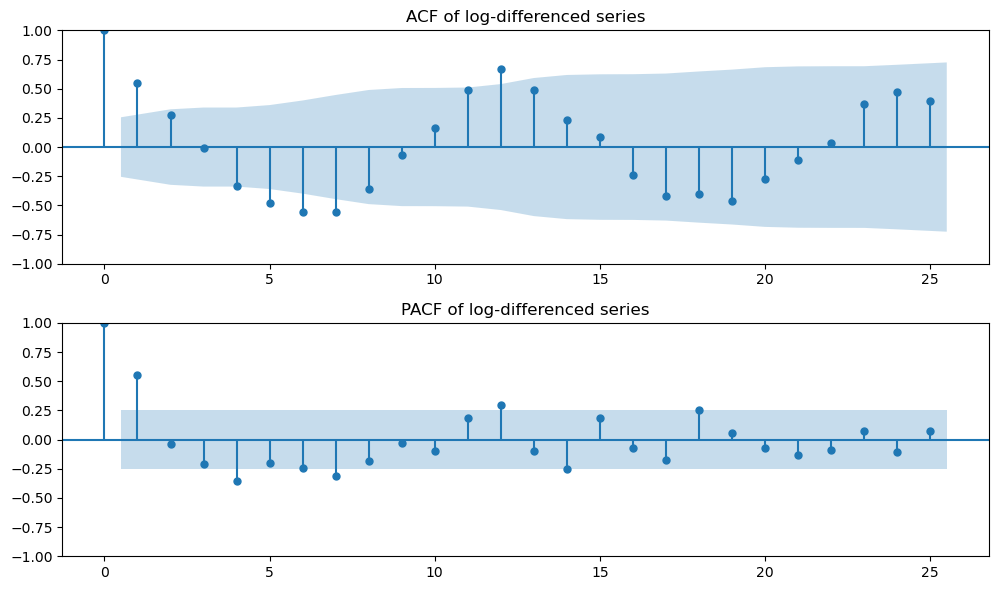

In [38]:
LAGS = 2.1 * PERIODS

fig, axes = plt.subplots(2, 1, figsize=(10, 6))

plot_acf(x, ax=axes[0], lags=LAGS)
axes[0].set_title("ACF of log-differenced series")

plot_pacf(x, ax=axes[1], lags=LAGS)
axes[1].set_title("PACF of log-differenced series")

plt.tight_layout()
plt.show()

## Variation playground

In [39]:
df_forecast = df[['values']].copy()
df_forecast

,values
period,
2020-02-29,2192091
2020-03-31,2308030
...,...
2024-11-30,2952111
2024-12-31,2669152


In [40]:
from modules import utils

# ARIMA baseline
df_forecast = utils.get_model_forecast(df_forecast, column='values', order=(12, 1, 1), horizon=96, forecast_exp=True)

# SARIMA candidates
df_forecast = utils.get_model_forecast(
    df_forecast, column='values', order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), horizon=96, forecast_exp=True
)

df_forecast = utils.get_model_forecast(
    df_forecast, column='values', order=(0, 1, 1), seasonal_order=(0, 1, 1, 12), horizon=96, forecast_exp=True
)

df_forecast = utils.get_model_forecast(
    df_forecast, column='values', order=(1, 1, 1), seasonal_order=(0, 1, 1, 12), horizon=96, forecast_exp=True
)

df_forecast = utils.get_model_forecast(
    df_forecast, column='values', order=(1, 1, 1), seasonal_order=(0, 1, 0, 12), horizon=96, forecast_exp=True
)

df_forecast

/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal movi

,values,"ARIMA(12,1,1)","SARIMA(1,1,1)(1,1,1,12)","SARIMA(0,1,1)(0,1,1,12)","SARIMA(1,1,1)(0,1,1,12)","SARIMA(1,1,1)(0,1,0,12)"
2020-02-29,2192091.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
2020-03-31,2308030.0,2.192092e+06,2.192091e+06,2.192091e+06,2.192091e+06,2.192091e+06
...,...,...,...,...,...,...
2032-11-30,NaN,3.928800e+06,6.937173e+06,8.208498e+06,6.817935e+06,6.708770e+06
2032-12-31,NaN,3.309672e+06,5.510814e+06,6.670243e+06,5.377723e+06,6.065664e+06


## Choose best model

### Forecast plot

In [41]:
d = 1
D = 1
s = 12

idx_offset = d + D * s
idx_offset

13

In [42]:
x = df_forecast.iloc[idx_offset:]
fig = x.plot(color="variable")
fig.update_layout(hovermode="x unified")

In [43]:
df_forecast = x.copy()

### Metrics review

In [44]:
x = df_forecast.dropna()
x

,values,"ARIMA(12,1,1)","SARIMA(1,1,1)(1,1,1,12)","SARIMA(0,1,1)(0,1,1,12)","SARIMA(1,1,1)(0,1,1,12)","SARIMA(1,1,1)(0,1,0,12)"
2021-03-31,3084289.0,2.623514e+06,2.569292e+06,2.569292e+06,2.569292e+06,2.569292e+06
2021-04-30,3774506.0,3.540812e+06,3.541887e+06,3.461876e+06,3.549437e+06,3.539951e+06
...,...,...,...,...,...,...
2024-11-30,2952111.0,3.266574e+06,3.247161e+06,3.376064e+06,3.251033e+06,3.194618e+06
2024-12-31,2669152.0,2.456012e+06,2.352166e+06,2.390803e+06,2.304380e+06,2.476853e+06


In [45]:
real = x.pop("values")
real

2021-03-31    3084289.0
2021-04-30    3774506.0
                ...    
2024-11-30    2952111.0
2024-12-31    2669152.0
Freq: ME, Name: values, Length: 46, dtype: float64

In [46]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd

# Example metrics
metrics = {
    "rmse": root_mean_squared_error,
    "mae": mean_absolute_error,
    "mape": mean_absolute_percentage_error,
}

In [47]:
d = {}
for k,v in metrics.items():
    metric = x.apply(lambda x: v(real, x))
    d[k] = metric
    
pd.DataFrame(d).style.background_gradient(cmap="Greens_r", axis=0).format(precision=2, thousands=",")

,rmse,mae,mape
"ARIMA(12,1,1)","252,448.01","202,566.52",0.06
"SARIMA(1,1,1)(1,1,1,12)","283,128.57","238,637.17",0.07
"SARIMA(0,1,1)(0,1,1,12)","301,350.33","258,551.57",0.08
"SARIMA(1,1,1)(0,1,1,12)","285,193.77","240,953.98",0.07
"SARIMA(1,1,1)(0,1,0,12)","306,931.01","249,173.67",0.08


In [48]:
df

,values,values_log,values_log_diff
period,,,
2020-02-29,2192091,14.600366,0.242422
2020-03-31,2308030,14.651905,0.051538
...,...,...,...
2024-11-30,2952111,14.898031,-0.338568
2024-12-31,2669152,14.797271,-0.100760


## Diagnostics to validate assumptions

### Model fit

Configure the best model based on the metrics review.

- SARIMAX
- ARIMA

In [49]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p, d, q = order = (0, 1, 1)
P, D, Q, s = seasonal_order = (0, 1, 1, 12)

model = SARIMAX(df["values_log"], order=order, seasonal_order=seasonal_order)
model_fit = model.fit()

/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



In [50]:
from statsmodels.tsa.arima.model import ARIMA

p, d, q = order = (12, 1, 1)

model = ARIMA(df["values_log"], order=order)
model_fit = model.fit()

/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



### Residuals

In [51]:
idx_offset = d + D * s

residuals = model_fit.resid[idx_offset:]
residuals

period
2021-03-31    0.161806
2021-04-30    0.063913
                ...   
2024-11-30   -0.101221
2024-12-31    0.083222
Freq: ME, Length: 46, dtype: float64

### Assumptions
#### Autocorrelation

##### Plot

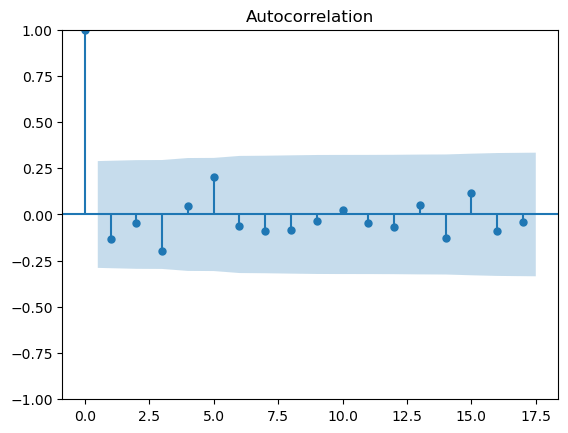

In [52]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals);

##### Test

In [53]:
from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(residuals, lags=[10, 20, 30]).style

,lb_stat,lb_pvalue
10,6.475496,0.773859
20,12.712413,0.889379
30,17.359786,0.968003


#### Normality

##### Plot

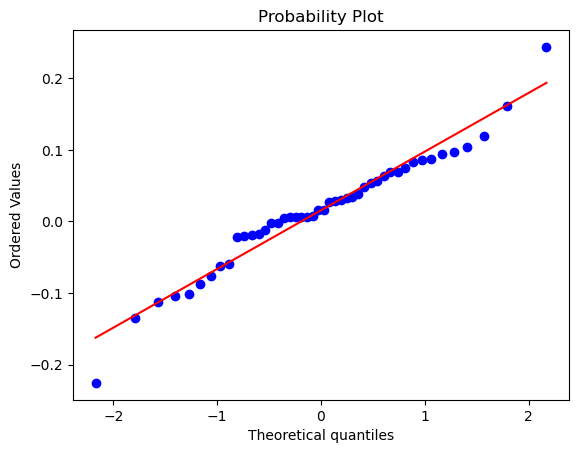

In [54]:
import matplotlib.pyplot as plt
from scipy import stats

fig, ax = plt.subplots()
stats.probplot(residuals, dist='norm', plot=ax);

##### Test

In [55]:
from scipy.stats import jarque_bera
jarque_bera(residuals)

SignificanceResult(statistic=np.float64(3.6214235651956637), pvalue=np.float64(0.16353769208264365))

#### Homoscedasticity

##### Plot

In [56]:
residuals.plot()

##### Test

In [57]:
from statsmodels.stats.diagnostic import het_arch
het_arch(residuals)

(np.float64(11.811455440465645),
 np.float64(0.22414847629317236),
 1.4067651363359275,
 0.23410193034776788)